<a href="https://colab.research.google.com/github/sonsona0205/sonsona_it20firstlabexam_wineprediction/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlxtend --quiet
!pip install openpyxl --quiet

In [2]:
from google.colab import files
print("If you want to upload a CSV from your computer, run: files.upload()")

If you want to upload a CSV from your computer, run: files.upload()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/Bakery.csv"

print("Set DATA_PATH variable to the CSV path and run the next cells.")


Mounted at /content/drive
Set DATA_PATH variable to the CSV path and run the next cells.


In [6]:
import pandas as pd
import os

DATA_PATH = "/content/drive/MyDrive/Bakery.csv"

assert os.path.exists(DATA_PATH), f"File not found at {DATA_PATH}. Upload or fix path and re-run this cell."

df = pd.read_csv(DATA_PATH)
print("Loaded. Shape:", df.shape)
display(df.head(10))

possible_tx_cols = [c for c in df.columns if c.lower().startswith("trans") or "id" in c.lower() or "order" in c.lower()]
possible_item_cols = [c for c in df.columns if c.lower() in ("item","items","product","productname","description","name") or "item" in c.lower() or "product" in c.lower()]

tx_col = possible_tx_cols[0] if possible_tx_cols else None
item_col = possible_item_cols[0] if possible_item_cols else None

print("Auto-detected transaction column:", tx_col)
print("Auto-detected item column:", item_col)

print("\nIf the detected column names are incorrect, edit tx_col and item_col below and re-run.")

Loaded. Shape: (20507, 5)


,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend
5,3,Cookies,2016-10-30 10:07:57,Morning,Weekend
6,4,Muffin,2016-10-30 10:08:41,Morning,Weekend
7,5,Coffee,2016-10-30 10:13:03,Morning,Weekend
8,5,Pastry,2016-10-30 10:13:03,Morning,Weekend
9,5,Bread,2016-10-30 10:13:03,Morning,Weekend


Auto-detected transaction column: TransactionNo
Auto-detected item column: Items

If the detected column names are incorrect, edit tx_col and item_col below and re-run.


In [7]:
assert 'tx_col' in globals() and tx_col is not None, "Please set tx_col variable to your transaction-id column name."
assert 'item_col' in globals() and item_col is not None, "Please set item_col variable to your item column name."


df[item_col] = df[item_col].astype(str).str.strip()
df = df[df[item_col] != ""].copy()


df_nodup = df.drop_duplicates(subset=[tx_col, item_col]).copy()
print("Original rows:", len(df), "After removing duplicate line-items:", len(df_nodup))


baskets = df_nodup.groupby(tx_col)[item_col].apply(lambda x: sorted(set(x))).reset_index()
baskets = baskets.rename(columns={item_col: "Items"})
print("Number of transactions:", len(baskets))
display(baskets.head(20))


OUT_DIR = "/content/association_results"
import os
os.makedirs(OUT_DIR, exist_ok=True)
baskets.to_csv(os.path.join(OUT_DIR, "cleaned_baskets.csv"), index=False)
print("Saved cleaned baskets to:", os.path.join(OUT_DIR, "cleaned_baskets.csv"))


Original rows: 20507 After removing duplicate line-items: 18887
Number of transactions: 9465


,TransactionNo,Items
0,1,[Bread]
1,2,[Scandinavian]
2,3,"[Cookies, Hot chocolate, Jam]"
3,4,[Muffin]
4,5,"[Bread, Coffee, Pastry]"
5,6,"[Medialuna, Muffin, Pastry]"
6,7,"[Coffee, Medialuna, Pastry, Tea]"
7,8,"[Bread, Pastry]"
8,9,"[Bread, Muffin]"
9,10,"[Medialuna, Scandinavian]"


Saved cleaned baskets to: /content/association_results/cleaned_baskets.csv


In [8]:

min_support = 0.01
min_confidence = 0.30

transactions = baskets['Items'].tolist()
n_trans = len(transactions)
print("Transactions:", n_trans)


try:
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori, association_rules
    te = TransactionEncoder()
    ohe = te.fit(transactions).transform(transactions)
    ohe_df = pd.DataFrame(ohe, columns=te.columns_)
    print("One-hot encoded shape:", ohe_df.shape)
    freq_itemsets = apriori(ohe_df, min_support=min_support, use_colnames=True)
    freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x: len(x))
    freq_itemsets = freq_itemsets.sort_values(['support','length'], ascending=[False, False]).reset_index(drop=True)
    mlxtend_available = True
    print("Used mlxtend apriori.")
except Exception as e:
    print("mlxtend not available or error. Falling back to a simple Apriori implementation. Error:", e)

    all_items = sorted({it for sub in transactions for it in sub})
    def encode_items(item_list):
        return {item: (item in item_list) for item in all_items}
    ohe_df = baskets['Items'].apply(encode_items).apply(pd.Series)
    print("One-hot encoded shape (fallback):", ohe_df.shape)


    from itertools import combinations
    min_support_count = max(1, int(min_support * n_trans))
    def support_count(itemset):
        s = 0
        for t in transactions:
            if set(itemset).issubset(set(t)):
                s += 1
        return s


    rows = []
    items = all_items
    L1 = []
    for item in items:
        cnt = support_count([item])
        if cnt >= min_support_count:
            L1.append((frozenset([item]), cnt))
    L = {1: L1}
    k = 2
    while True:
        prev = L.get(k-1, [])
        if not prev:
            break
        prev_sets = [set(x[0]) for x in prev]
        candidates = set()
        for i in range(len(prev_sets)):
            for j in range(i+1, len(prev_sets)):
                union = prev_sets[i] | prev_sets[j]
                if len(union) == k:

                    ok = True
                    for subset in combinations(union, k-1):
                        if frozenset(subset) not in [x[0] for x in prev]:
                            ok = False
                            break
                    if ok:
                        candidates.add(frozenset(union))
        Lk = []
        for c in sorted(candidates):
            cnt = support_count(c)
            if cnt >= min_support_count:
                Lk.append((c, cnt))
        if not Lk:
            break
        L[k] = Lk
        k += 1

    for k, itemsets in L.items():
        for itemset, cnt in itemsets:
            rows.append({'itemsets': set(itemset), 'support_count': cnt, 'support': cnt / n_trans, 'length': len(itemset)})
    freq_itemsets = pd.DataFrame(rows).sort_values(['support','length'], ascending=[False, False]).reset_index(drop=True)
    mlxtend_available = False


freq_itemsets.to_csv(os.path.join(OUT_DIR, "frequent_itemsets.csv"), index=False)
print("Saved frequent itemsets to:", os.path.join(OUT_DIR, "frequent_itemsets.csv"))


print("\nTop frequent itemsets:")
if mlxtend_available:
    display(freq_itemsets.head(30))
else:
    display(freq_itemsets.head(30))


Transactions: 9465
One-hot encoded shape: (9465, 94)
Used mlxtend apriori.
Saved frequent itemsets to: /content/association_results/frequent_itemsets.csv

Top frequent itemsets:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,support,itemsets,length
0,0.478394,(Coffee),1
1,0.327205,(Bread),1
2,0.142631,(Tea),1
3,0.103856,(Cake),1
4,0.090016,"(Bread, Coffee)",2
5,0.086107,(Pastry),1
6,0.071844,(Sandwich),1
7,0.061807,(Medialuna),1
8,0.058320,(Hot chocolate),1
9,0.054728,"(Cake, Coffee)",2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [9]:
import numpy as np
from itertools import combinations

if mlxtend_available:

    rules = association_rules(freq_itemsets, metric="confidence", min_threshold=min_confidence)

    rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(sorted(list(x))))
    rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(sorted(list(x))))
    rules = rules.sort_values(['lift','confidence','support'], ascending=[False, False, False]).reset_index(drop=True)
else:


    if 'support' not in freq_itemsets.columns:
        freq_itemsets['support'] = freq_itemsets['support_count'] / n_trans
    rows = []
    for _, r in freq_itemsets.iterrows():
        itemset = set(r['itemsets'])
        if len(itemset) < 2:
            continue
        sup = r['support']
        for rsize in range(1, len(itemset)):
            for antecedent in combinations(sorted(itemset), rsize):
                antecedent = set(antecedent)
                consequent = itemset - antecedent
                # counts
                ant_cnt = 0
                cons_cnt = 0
                for t in transactions:
                    if antecedent.issubset(set(t)):
                        ant_cnt += 1
                    if consequent.issubset(set(t)):
                        cons_cnt += 1
                if ant_cnt == 0:
                    continue
                conf = sup / (ant_cnt / n_trans)
                lift = conf / (cons_cnt / n_trans) if cons_cnt>0 else np.nan
                if conf >= min_confidence:
                    rows.append({
                        'antecedents': frozenset(antecedent),
                        'consequents': frozenset(consequent),
                        'support': sup,
                        'confidence': conf,
                        'lift': lift,
                        'antecedents_str': ', '.join(sorted(list(antecedent))),
                        'consequents_str': ', '.join(sorted(list(consequent)))
                    })
    rules = pd.DataFrame(rows)
    if not rules.empty:
        rules = rules.sort_values(['lift','confidence','support'], ascending=[False, False, False]).reset_index(drop=True)
    else:
        rules = pd.DataFrame(columns=['antecedents','consequents','support','confidence','lift','antecedents_str','consequents_str'])


rules.to_csv(os.path.join(OUT_DIR, "association_rules.csv"), index=False)
print("Saved association rules to:", os.path.join(OUT_DIR, "association_rules.csv"))


print("\nTop association rules (by lift):")
if not rules.empty:
    display(rules[['antecedents_str','consequents_str','support','confidence','lift']].head(30))
else:
    print("No rules found with current thresholds. Try lowering min_support or min_confidence.")


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Saved association rules to: /content/association_results/association_rules.csv

Top association rules (by lift):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,antecedents_str,consequents_str,support,confidence,lift
0,Toast,Coffee,0.023666,0.704403,1.472431
1,Spanish Brunch,Coffee,0.010882,0.598837,1.251766
2,Medialuna,Coffee,0.035182,0.569231,1.189878
3,Pastry,Coffee,0.047544,0.552147,1.154168
4,Alfajores,Coffee,0.019651,0.540698,1.130235
5,Juice,Coffee,0.020602,0.534247,1.116750
6,Sandwich,Coffee,0.038246,0.532353,1.112792
7,Cake,Coffee,0.054728,0.526958,1.101515
8,Scone,Coffee,0.018067,0.522936,1.093107
9,Cookies,Coffee,0.028209,0.518447,1.083723


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

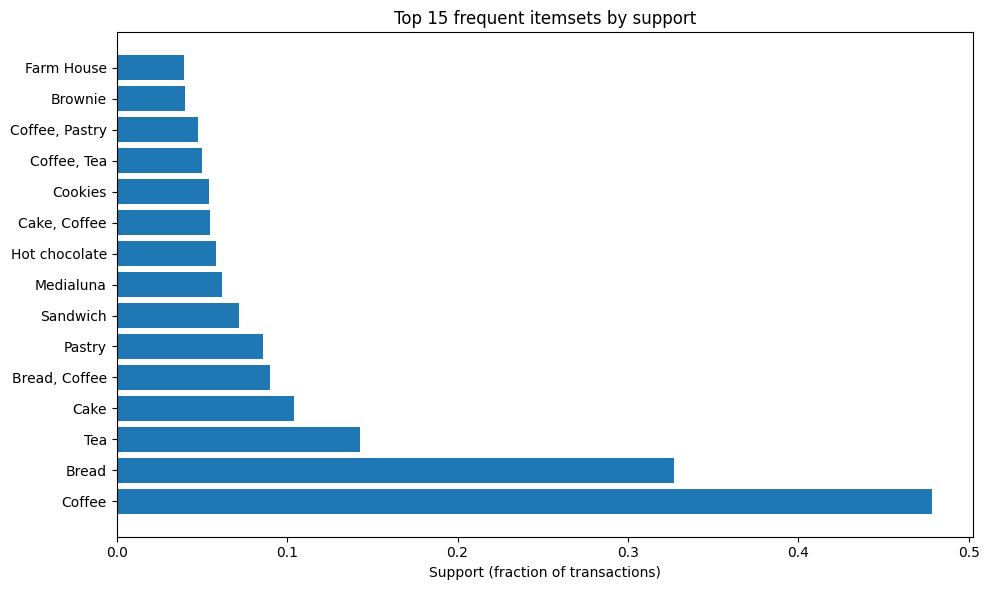

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

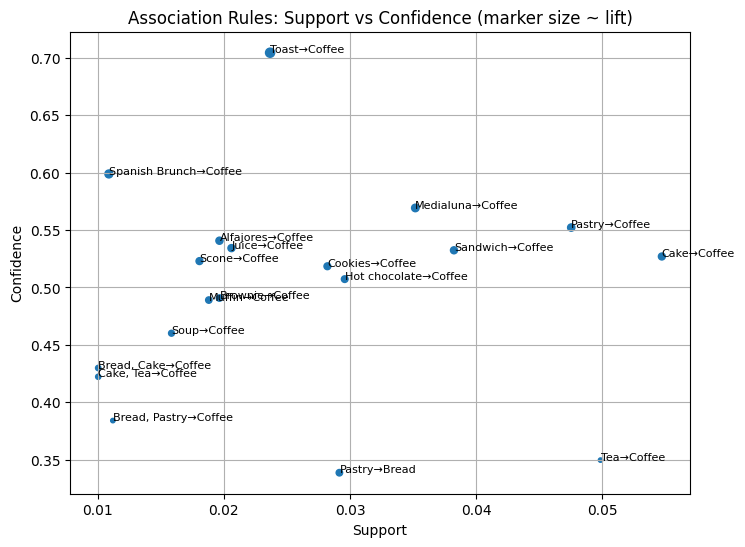

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [10]:
import matplotlib.pyplot as plt
import numpy as np


top_n = 15
if mlxtend_available:

    freq_itemsets['itemset_str'] = freq_itemsets['itemsets'].apply(lambda x: ', '.join(sorted(list(x))))
else:
    freq_itemsets['itemset_str'] = freq_itemsets['itemsets'].apply(lambda x: ', '.join(sorted(list(x))))

top_freq = freq_itemsets.sort_values('support', ascending=False).head(top_n)
plt.figure(figsize=(10,6))
plt.barh(range(len(top_freq)), top_freq['support'][::-1])
plt.yticks(range(len(top_freq)), top_freq['itemset_str'][::-1])
plt.xlabel("Support (fraction of transactions)")
plt.title(f"Top {top_n} frequent itemsets by support")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


if not rules.empty:
    plt.figure(figsize=(8,6))
    x = rules['support']
    y = rules['confidence']
    s = np.clip((rules['lift'] - 1) * 50 + 20, 10, 300)
    plt.scatter(x, y, s=s)
    for i, row in rules.head(20).iterrows():
        plt.text(row['support'], row['confidence'], row['antecedents_str'] + "→" + row['consequents_str'], fontsize=8)
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.title("Association Rules: Support vs Confidence (marker size ~ lift)")
    plt.grid(True)
    plt.show()
else:
    print("No rules to plot.")


In [11]:
import os
print("Saved results in directory:", OUT_DIR)
for f in os.listdir(OUT_DIR):
    print("-", f)




Saved results in directory: /content/association_results
- frequent_itemsets.csv
- association_rules.csv
- cleaned_baskets.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [12]:
def make_insights(rules_df, top_k=5):
    if rules_df.empty:
        return "No strong association rules were found with the chosen thresholds. Try lowering min_support or min_confidence."
    s = []
    top = rules_df.sort_values('lift', ascending=False).head(top_k)
    s.append("Automatic insights from association rules:")
    for i, row in top.iterrows():
        s.append(f"- Rule: WHEN customers buy [{row['antecedents_str']}], they also buy [{row['consequents_str']}] "
                 f"(support={row['support']:.3f}, confidence={row['confidence']:.2%}, lift={row['lift']:.2f}).")

    lifts_pos = (rules_df['lift'] > 1).sum()
    s.append(f"\nOverall, {lifts_pos} of {len(rules_df)} discovered rules have lift > 1, indicating positive associations where the presence of antecedents increases the likelihood of consequents.")
    s.append("Consider using these insights for product placement or morning/weekend promotions. For example, bundling frequently co-purchased items can increase average transaction value.")
    return "\n".join(s)

insight_text = make_insights(rules)
print(insight_text)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Automatic insights from association rules:
- Rule: WHEN customers buy [Toast], they also buy [Coffee] (support=0.024, confidence=70.44%, lift=1.47).
- Rule: WHEN customers buy [Spanish Brunch], they also buy [Coffee] (support=0.011, confidence=59.88%, lift=1.25).
- Rule: WHEN customers buy [Medialuna], they also buy [Coffee] (support=0.035, confidence=56.92%, lift=1.19).
- Rule: WHEN customers buy [Pastry], they also buy [Coffee] (support=0.048, confidence=55.21%, lift=1.15).
- Rule: WHEN customers buy [Alfajores], they also buy [Coffee] (support=0.020, confidence=54.07%, lift=1.13).

Overall, 14 of 19 discovered rules have lift > 1, indicating positive associations where the presence of antecedents increases the likelihood of consequents.
Consider using these insights for product placement or morning/weekend promotions. For example, bundling frequently co-purchased items can increase average transaction value.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In this laboratory exercise, we applied association rule mining to a bakery transaction dataset to
discover frequent itemsets and purchasing patterns. After preprocessing, we grouped items into
transaction baskets and removed duplicates. Using the Apriori algorithm with minimum support set at
1% and minimum confidence at 30%, we generated a set of frequent item combinations and
corresponding association rules.
The results revealed several interesting insights. For example, one of the strongest rules observed was
that customers who purchase Toast are very likely to also purchase Coffee, with a confidence of about
70% and a lift of 1.47. This indicates that Toast and Coffee are positively correlated and tend to appear
together more often than would be expected by chance. In fact, 14 of the 19 generated rules had lift
values greater than 1, which shows that the majority of item relationships in this dataset exhibit
meaningful associations.
These findings can be valuable for business strategy. For instance, the strong relationship between
Coffee and Toast suggests opportunities for cross-selling, promotional bundles, or targeted marketing
during morning hours. By analyzing such associations, businesses can better understand customer
behavior, optimize product placement, and ultimately enhance sales performance.